# Building a Safe Haven

In [13]:
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%matplotlib inline

# Widgets
from ipywidgets import interact

# Optimization
from scipy.optimize import fsolve
from scipy.stats import gmean

# Runtime measurements
import time

# Working with dates
import datetime
from dateutil.relativedelta import relativedelta

# Financial Data
import quandl

# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Setting local module path
import os
import sys
module_path = os.path.abspath(os.path.join('../modules')) 
sys.path.insert(0, module_path)

# Local module import
import petersburgmerchant
import nietzschesdemon
import kellycriterion


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Chapter Two: Nature's Admonition

### The Saint Petersburg Paradox

In [3]:
# Setting payoff in currency of choice
payoffs = [1, 2, 6, 22, 200, 1000000]

In [4]:
# Setting amount of wealth and size of bet in chosen currency (hey, don't use another one. This is no currency converter)
wealth_amount = 100000
bet_size = 50000

### Emolumentum Medium

Ending wealth per bet
$$ \text{Ending Wealth} = \text{Starting Wealth} - Wager + Payoff $$

For Elolumentum Medium of all bets, were $ n_{wealth} $ is the amount of bets
$$ EM =  \frac{\sum(\log(\text{Ending Wealth}_{n}))}{n_{wealth}} $$

Bernouilli's Expected Value (BEV) is calculated by the exponential function of EM
$$ BEV = e^{EM} $$

In [5]:
# Calculating wager corresponding to set bet_size
wager = petersburgmerchant.bev(payoffs, wealth_amount, bet_size) 
print(wager)


83113.90899349027


If we do the Saint Petersburg Wager with a wealth of 100000 and a bet of 50000 under the given payoffs, we expect final wealth of 83.113, which makes it less than our original wealth. Therefore we shouldn't bet.

### Geometric Average

#### Solution 1: Iterating through possible solutions of BEV

In [7]:
def bet_size_solution1(payoffs, wealth_amount):
    """
    Calculate the optimal bet size using iteration through bev().

    Arguments:
    - payoffs: A list of payoff values
    - wealth_amount: The total wealth amount

    Returns:
    - bet_size: The optimal bet size
    - runtime: The execution time in seconds
    """
    bet_size = 0
    epsilon = 0.001  # Accuracy of the estimate
    max_iterations = wealth_amount + 1  # Maximum number of iterations

    start_time = time.time()  # Start time for runtime measurement

    for _ in range(max_iterations):
        # Calculation of BEV for the current bet
        wager = petersburgmerchant.bev(payoffs, wealth_amount, bet_size)

        # Finding the solution
        if abs(wager - wealth_amount) < epsilon:
            break

        # Update the bet size based on the difference between the wager and wealth_amount
        bet_size += wager - wealth_amount

    end_time = time.time()  # End time for runtime measurement
    runtime = end_time - start_time

    return int(bet_size), runtime

bet_size, runtime = bet_size_solution1(payoffs, wealth_amount)
print("Optimal Bet Size:", bet_size)
print("Runtime:", runtime, "seconds")


Optimal Bet Size: 37708
Runtime: 0.0001227855682373047 seconds


This calculation is nothing else than the calculation of the geometric mean.

$$ \text{GM} = \sqrt[n]{(x_1 + k) \cdot (x_2 + k) \cdot \ldots \cdot (x_n + k)} = \left( (x_1 + k)\cdot (x_2 + k)\cdot \ldots \cdot (x_n + k)\right)^{\frac{1}{n}} $$

#### Solution 2: Finding the correct formula with 'fsolve' for given list

In [8]:
def bet_size_solution2(wealth_amount, payoffs):
    """
    Calculate the optimal bet size using the geometric mean method.
    
    Arguments:
    - wealth_amount: Total wealth amount
    - payoffs: List of payoffs for each possible outcome of the bet
    
    Returns:
    - bet_size: Optimal bet size
    - runtime: Runtime in seconds
    """
    n = len(payoffs)
    
    # Function for calculating the geometric mean
    def geom_mean(bet_size):
        product = 1
        for value in payoffs:
            product *= value + bet_size
        return math.pow(product, 1/n) - wealth_amount
    
    # Using 'fsolve' from SciPy to calculate bet_size
    initial_guess = 0  # Starting value for bet_size
    
    start_time = time.time()  # Starting time for runtime measurement
    bet_size = wealth_amount - fsolve(geom_mean, initial_guess)
    end_time = time.time()  # End time for runtime measurement
    runtime = end_time - start_time
    
    return int(bet_size[0]), runtime

bet_size, runtime = bet_size_solution2(wealth_amount, payoffs)
print("Optimal Bet Size:", bet_size)
print("Runtime:", runtime, "seconds")

Optimal Bet Size: 37708
Runtime: 0.0006186962127685547 seconds


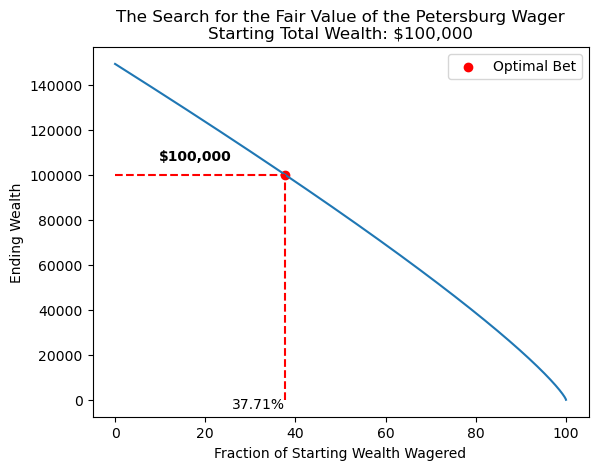

In [9]:
petersburgmerchant.betting_plot(payoffs, wealth_amount, bet_size)

### The other Saint Petersburg Paradox

In [10]:
interact(petersburgmerchant.investment_recovery_plot, loss_value=(-95, -5), step=1)

interactive(children=(IntSlider(value=-50, description='loss_value', max=-5, min=-95), Output()), _dom_classes…

<function petersburgmerchant.investment_recovery_plot(loss_value)>

## Chapter Three: The Eternal Return

### Dice with Schrödinger's Demon (N = 1)

In [41]:
# Calculating the average of a weighted dice roll in percent, cutting off at two decimal places
schroedingers_dice = (np.average([0.5, 1.05, 1.5], weights=[1/6, 4/6, 1/6]) - 1 ) * 100
schroedingers_dice = round(schroedingers_dice, 2)
print("Dice with Schrödinger's Demon (N = 1):", schroedingers_dice, "%")

Dice with Schrödinger's Demon (N = 1): 3.33 %


### Dice with Nietzsche's Demon (N = ∞)

In [14]:
# Calculating the geometric mean of a weighted dice roll in percent, cutting off at two decimal places
nietzsches_dice = (gmean([0.5, 1.05, 1.5], weights=[1/6, 4/6, 1/6]) - 1 ) * 100
nietzsches_dice = round(nietzsches_dice, 2)
print("Dice with Nietzsche's Demon (N = ∞):", nietzsches_dice, "%")

Dice with Nietzsche's Demon (N = ∞): -1.53 %


In [15]:
# Setting dice rules
dice_outcomes = np.array([0.5, 1.05, 1.05, 1.05, 1.05, 1.5])
num_rolls = 300
num_walks = 10000

In [44]:
# Do a random walk
def dice_random_walk(num_walks, num_rolls, dice_outcomes):
    """
    Perform random walks based on weighted dice rolls.

    Arguments:
    - num_walks: Number of random walks to perform
    - num_rolls: Number of rolls per walk
    - dice_outcomes: Array of dice outcomes

    Returns:
    - walks: Array of random walks
    - percentiles: 5th, 50th (median) and 95th Percentiles of the random walks
    - median_walk: Median walk
    - median_return: Geometric mean of dice' chances
    - percentage_change: Percentage change from 1 for each walk
    """
    # Perform random walks
    walks = np.cumprod(np.random.choice(dice_outcomes, size=(num_walks, num_rolls)), axis=1)

    # Calculate percentiles
    percentiles = np.percentile(walks, [5, 50, 95], axis=0)
    median_walk = percentiles[1]

    # Calculate geometric mean for each walk
    geometric_means = np.power(walks[:, -1], 1 / num_rolls)
    median_return = (gmean(dice_outcomes) - 1) * 100

    # Calculate percentage change from 1
    percentage_change = (geometric_means - 1) * 100

    return walks, percentiles, median_walk, median_return, percentage_change


In [45]:
def plot_random_walk_frequency_distribution(num_walks, num_rolls, dice_outcomes):
    """
    Plot random walks of weighted dice rolls.

    Arguments:
    - num_walks: Number of random walks to perform
    - num_rolls: Number of rolls per walk
    - dice_outcomes: Array of dice outcomes

    Returns:
    None
    """

    walks, percentiles, median_walk, median_return, percentage_change = dice_random_walk(num_walks, num_rolls, dice_outcomes)

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Plot random walks
    ax1.plot(range(num_rolls), walks.T, color='gray', alpha=0.3)

    # Plot 5th and 95th percentiles
    ax1.plot(range(num_rolls), percentiles[2], color='black', label='95th percentile')
    ax1.plot(range(num_rolls), percentiles[0], color='black', label='5th percentile')

    # Plot median walk
    ax1.plot(range(num_rolls), median_walk, color='red', label='Median')

    # Set axis labels and plot title
    ax1.set_xlabel('Rolls')
    ax1.set_ylabel('Ending Wealth')
    ax1.set_title('You Get What You Get, Not What You Expect')

    # Set logarithmic scale on the y-axis
    ax1.set_yscale('log')

    # Custom formatter for y-axis ticks
    def wealth_formatter(x, pos):
        if x >= 1:
            return f'{int(x):,}'
        else:
            return f'{float(x)}'

    formatter = FuncFormatter(wealth_formatter)
    ax1.yaxis.set_major_formatter(formatter)

    # Plot geometric mean and histogram
    ax2.axhline(median_return, color='red', linestyle='--', label='Geometric Mean')
    ax2.hist(percentage_change, bins=30, orientation='horizontal', color='grey', alpha=0.7)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Geometric Average Return')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.05)

    # Display the plot
    plt.show()


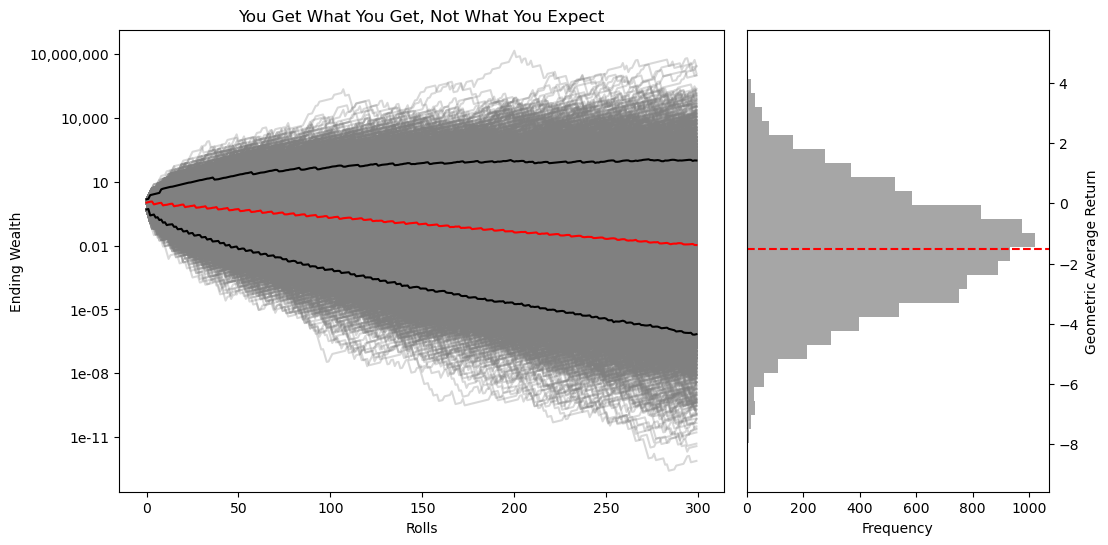

In [20]:
# Plotting frequency distribution of given number of random walks and rolls
nietzschesdemon.plot_random_walk_frequency_distribution(num_walks, num_rolls, dice_outcomes)

In [47]:
def plot_random_walk_geom_average(num_walks, num_rolls, dice_outcomes):
    """
    Plot random walks of weighted dice rolls.

    Arguments:
    - num_walks: Number of random walks to perform
    - num_rolls: Number of rolls per walk
    - dice_outcomes: Array of dice outcomes

    Returns:
    None
    """
    # Use dice_random_walk() to calculate the median_return and percentage_change.
    _, _, _, median_return, percentage_change = dice_random_walk(num_walks, num_rolls, dice_outcomes)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the geometric mean as a vertical line
    ax.axvline(median_return, color='red', linestyle='--', label='Geometric Mean')

    # Plot the histogram of percentage_change
    bins = np.linspace(np.min(percentage_change), np.max(percentage_change), 30)
    counts, bins, _ = ax.hist(percentage_change, bins=bins, orientation='vertical', color='lightgrey', alpha=0.7)
    mid_points = (bins[:-1] + bins[1:]) / 2
    ax.plot(mid_points, counts, color='black', linewidth=2)

    ax.set_xlabel('Geometric Average Return')
    ax.set_ylabel('Frequency')

    # Display the plot
    plt.show()

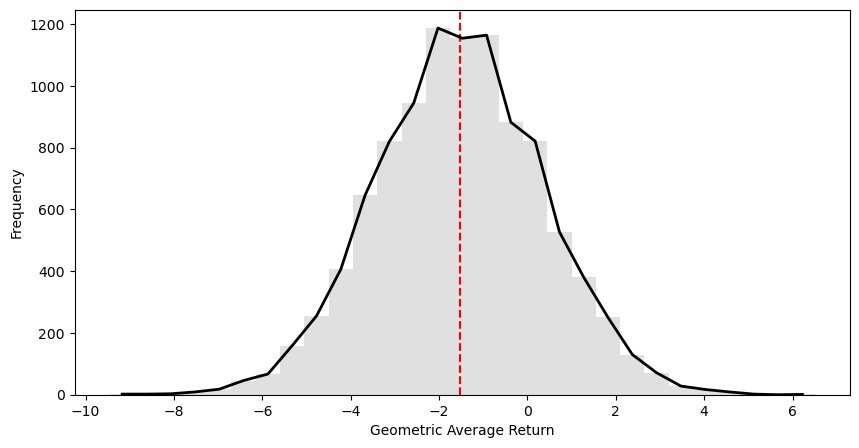

In [48]:
# Plotting 10000 random walks of 300 rolls each
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice_outcomes)

## Kelly Criterion

In [49]:
# Outcome of cash (no win/no loss)
cash_outcomes = np.array([1, 1, 1, 1, 1, 1])
dice_to_cash_ratio = np.array([0.4, 0.6])

In [50]:
def extract_variable_name(var, globals_dict):
    """
    This function extracts the variable name from the global variables dictionary, 
    and returns the first word capitalized.

    Arguments:    
    - var: A variable whose name needs to be extracted
    - globals_dict: A dictionary of global variables

    Returns:
    A string with the first word of the variable name capitalized
    """
    name_list = [name for name in globals_dict if globals_dict[name] is var]
    if name_list:
        variable_name = name_list[0]
        variable_name_title = variable_name.split('_')[0].title()
        return variable_name_title
    else:
        return None

In [51]:
def weighted_average(dice_outcomes, cash_outcomes, dice_to_cash_ratio):
    """
    This function calculates the weighted average for each pair of values in the 
    first two arrays based on the ratio in the third array.
    
    Arguments:
    - dice_outcomes: A numpy array with the dice outcomes
    - cash_outcomes: A numpy array with the cash outcomes
    - dice_to_cash_ratio: A numpy array with two elements representing the weights for dice and cash
    
    Return:
    - A numpy array with the weighted averages
    """
    
     # Make sure all arrays have the same length
    assert len(dice_outcomes) == len(cash_outcomes), "The first two arrays must have the same length"
    assert len(dice_to_cash_ratio) == 2, "The ratio array must have exactly two elements"

    dice_weight, cash_weight = dice_to_cash_ratio
    weighted_averages = []

    for dice, cash in zip(dice_outcomes, cash_outcomes):
        weighted_average = dice * dice_weight + cash * cash_weight
        weighted_averages.append(weighted_average)

    return np.array(weighted_averages)

In [52]:
def kelly_criterion(dice_outcomes, cash_outcomes, dice_to_cash_ratio):
    """
    Calculate the optimal fraction of wealth to bet on each roll of the dice.

    Arguments:
    - dice_outcomes: Array of dice outcomes
    - cash_outcomes: Array of cash outcomes
    - dice_to_cash_ratio: Array of ratios representing the allocation of wealth to dice and cash outcomes

    Returns:
    - df_kelly: DataFrame containing the arithmetic and geometric means of the outcomes
    """

    # Check whether the dice_outcomes and cash_outcomes are of the same length, and raise an error if not
    assert len(dice_outcomes) == len(cash_outcomes), 'The dice_outcomes and cash_outcomes arrays must be of the same length.'

    # Check whether dice_to_cash_ratio sums to 1, and raise an error if not
    assert np.isclose(np.sum(dice_to_cash_ratio), 1), 'The dice_to_cash_ratio must sum to 1.'

    # Calculate the arithmetic and geometric mean of the dice outcomes
    arith_mean_dice = (np.mean(dice_outcomes) - 1) * 100
    geom_mean_dice = (gmean(dice_outcomes) - 1) * 100

    # Calculate the arithmetic and geometric mean of the cash outcomes
    arith_mean_cash = (np.mean(cash_outcomes) - 1) * 100
    geom_mean_cash = (gmean(cash_outcomes) - 1) * 100

    # Calculate the arithmetic and geometric mean of the combined outcomes
    combined_outcomes = dice_to_cash_ratio[0] * dice_outcomes + dice_to_cash_ratio[1] * cash_outcomes
    arith_mean_combined = (np.mean(combined_outcomes) - 1) * 100
    geom_mean_combined = (gmean(combined_outcomes) - 1) * 100

    # Calculate cost and net
    cost = arith_mean_combined - arith_mean_dice
    net = geom_mean_combined - geom_mean_dice

    # Create a dictionary with the calculated values
    data = {
        'arith_avg': [arith_mean_dice, arith_mean_cash, arith_mean_combined, cost],
        'geom_avg': [geom_mean_dice, geom_mean_cash, geom_mean_combined, net]
    }

    # Create a DataFrame from the dictionary
    df_kelly = pd.DataFrame(data, index=['dice_roll', 'cash', 'combined', 'net/cost'])
    return df_kelly

df_kelly = kelly_criterion(dice_outcomes, cash_outcomes, dice_to_cash_ratio)
df_kelly


,arith_avg,geom_avg
dice_roll,3.333333,-1.530195
cash,0.000000,0.000000
combined,1.333333,0.641860
net/cost,-2.000000,2.172055


In [53]:
def plot_dice_distribution(ax, dice_outcomes):
    """
    Plot the distribution of outcomes of a dice roll.

    Arguments:
    - dice_outcomes: Array of dice outcomes

    Returns:
    None
    """
    # Calculate unique values and their counts
    unique_values, counts = np.unique(dice_outcomes, return_counts=True)

    # Convert unique values to percentage and add % sign
    unique_values = [(value - 1) * 100 for value in unique_values]
    unique_values = [f'{value:.0f}% ' for value in unique_values]

    # Plot the bar chart
    ax.bar(unique_values, counts)
    ax.set_xlabel('--------------------------------------------------------------------------------')
    ax.set_ylabel('Dice Roll Distribution')
    ax.set_title('Xs and Os Profile: The Kelly Criterion')
    ax.set_yticks(np.arange(min(counts), max(counts) + 1, 1))  # Set integer ticks on y-axis


In [54]:
def plot_dice_outcome(ax, dice_outcomes):
    """
    This function takes in an Axes object and an array of dice outcomes, and plots the winning probabilities
    based on the dice outcomes on the Axes.

    Arguments:
    - ax: An Axes object where the plot will be drawn
    - dice_outcomes: An array containing the outcomes of dice rolls

    Returns:
    None
    """
    
    # Extract the variable name of the dice outcomes for labeling purposes
    dice_name = extract_variable_name(dice_outcomes, globals())

    # Calculate the winning probabilities based on the dice outcomes
    win_probabilities_dice = [(outcome - 1.0) * 100 for outcome in dice_outcomes]

    # Prepare the categories for the x-axis
    categories_dice = [str((outcome - 1) * 100) + "%" for outcome in dice_outcomes]

    # Plot the winning probabilities
    ax.plot(categories_dice, win_probabilities_dice, marker='x')  # 'x' marker is used

    # Set the limits for the y-axis
    ax.set_ylim([-50, 100])  # the limits are set from -50 to 100

    # Set the label for the y-axis
    ax.set_ylabel(dice_name + " Roll")  # the y-axis is labeled as "[dice_name] Roll"

    # Enable the grid
    ax.grid(True)

    # Remove x-axis labels
    ax.set_xticks([])
    
    # Get arithmetic and geometric mean of dice outcomes
    arith_mean_dice = df_kelly.at['dice_roll', 'arith_avg']
    geom_mean_dice = df_kelly.at['dice_roll', 'geom_avg']

    # Add annotations for arithmetic and geometric mean
    ax.text(0.02, 0.98, f'ARITHM AVG: {arith_mean_dice:.2f}%', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.02, 0.88, f'GEOM AVG: {geom_mean_dice:.2f}%', transform=ax.transAxes, verticalalignment='top')


In [55]:
def plot_cash_outcome(ax, dice_outcomes, cash_outcomes):
    """
    This function creates a subplot of cash outcomes based on the provided dice and cash outcomes.

    Arguments:
    - ax: A matplotlib.axes.Axes object. The plot will be drawn on this Axes.
    - dice_outcomes: A numpy array with the dice outcomes
    - cash_outcomes: A numpy array with the cash outcomes

    Return:
    None
    """

    # Extract the variable name of cash_outcomes
    cash_name = extract_variable_name(cash_outcomes, globals())

    # Determine the number of unique categories based on dice outcomes
    n_categories = len(np.unique(dice_outcomes))

    # Reshape cash outcomes according to the number of categories
    cash_outcomes_reshaped = np.array_split(cash_outcomes, n_categories)

    # Calculate the winning probabilities for cash outcomes
    win_probabilities_cash = [(np.mean(outcome) - 1.0) * 100 for outcome in cash_outcomes_reshaped]

    # Create categories for cash outcomes
    categories_cash = [str(i+1) for i, _ in enumerate(cash_outcomes_reshaped)]

    # Create a plot with 'o' as a marker
    ax.plot(categories_cash, win_probabilities_cash, marker='o')

    # Set the limit for the y-axis
    ax.set_ylim([-50, 100])

    # Set the label for the y-axis
    ax.set_ylabel(cash_name)

    # Set the x-axis label
    ax.set_xlabel('=====================================================================================')

    # Enable grid
    ax.grid(True)

    # Remove x-axis labels
    ax.set_xticks([])

    # Calculate the arithmetic and geometric mean of the dice outcomes
    arith_mean_cash = df_kelly.at['cash', 'arith_avg']
    geom_mean_cash = df_kelly.at['cash', 'geom_avg']

    # Add annotations for arithmetic and geometric mean
    ax.text(0.02, 0.98, f'ARITHM AVG: {arith_mean_cash:.2f}%', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.02, 0.88, f'GEOM AVG: {geom_mean_cash:.2f}%', transform=ax.transAxes, verticalalignment='top')

In [56]:
def plot_combined_outcome(ax, dice_outcomes, cash_outcomes, dice_to_cash_ratio):
    """
    This function plots the weighted average outcomes based on the provided ratio.

    Arguments:
    - ax: The subplot axis to draw on
    - dice_outcomes: A numpy array with the dice outcomes
    - cash_outcomes: A numpy array with the cash outcomes
    - dice_to_cash_ratio: A numpy array with two elements representing the weights for dice and cash

    Returns:
    None
    """
    # Extract variable names for labels
    dice_name = extract_variable_name(dice_outcomes, globals())
    cash_name = extract_variable_name(cash_outcomes, globals())

    # Calculate the weighted average of the outcomes
    weighted_avg_outcomes = weighted_average(dice_outcomes, cash_outcomes, dice_to_cash_ratio)
    
    # Convert outcomes to percentage probabilities
    win_probabilities_weighted = [(outcome - 1.0) * 100 for outcome in weighted_avg_outcomes]

    # Convert outcomes to percentage categories for plotting
    categories_weighted = [str((outcome - 1) * 100) + "%" for outcome in weighted_avg_outcomes]

    # Plot the weighted average outcomes
    ax.plot(categories_weighted, win_probabilities_weighted, marker='^')

    # Set the y-axis limits
    ax.set_ylim([-50, 100])

    # Set the y-axis label
    ax.set_ylabel(f"{dice_to_cash_ratio[0] * 100} % " + dice_name + " and " + f"{dice_to_cash_ratio[1] * 100} % " + cash_name)

    # Enable the grid
    ax.grid(True)

    # Remove x-axis labels
    ax.set_xticks([])

    # Calculate the arithmetic and geometric mean of the dice outcomes
    arith_mean_combined = df_kelly.at['combined', 'arith_avg']
    geom_mean_combined = df_kelly.at['combined', 'geom_avg']

    cost = df_kelly.at['net/cost', 'arith_avg']
    net = df_kelly.at['net/cost', 'geom_avg']

    # Add annotations for arithmetic and geometric mean
    ax.text(0.02, 0.98, f'ARITHM AVG: {arith_mean_combined:.2f}%' + f' (Cost: {cost:.2f}%)', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.02, 0.88, f'GEOM AVG: {geom_mean_combined:.2f}%' + f' (Net: +{net:.2f}%)', transform=ax.transAxes, verticalalignment='top')

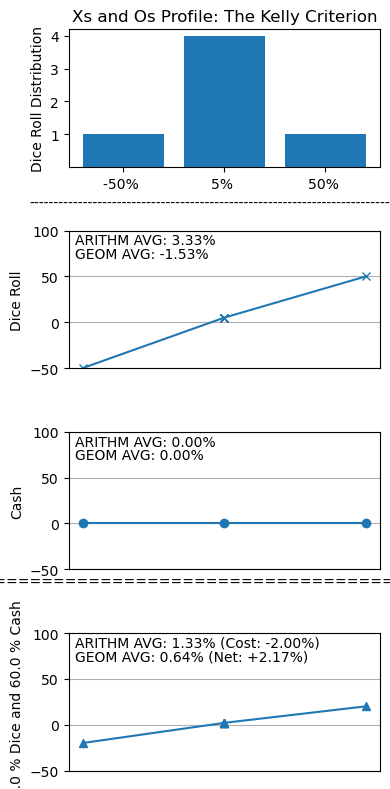

In [57]:
def plot_kelly_criterion(dice_outcomes, cash_outcomes, dice_to_cash_ratio):
    """
    This function calculates the weighted average for each pair of values in the 
    first two arrays based on the ratio in the third array.

    Arguments:
    - dice_outcomes: A numpy array with the dice outcomes
    - cash_outcomes: A numpy array with the cash outcomes
    - dice_to_cash_ratio: A numpy array with two elements representing the weights for dice and cash

    Return:
    None
    """
    # Create a figure with 4 subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(4, 8))

    # Subplot 1: Distribution of dice outcomes
    plot_dice_distribution(ax1, dice_outcomes)

    # Subplot 2: Height of dice outcome
    plot_dice_outcome(ax2, dice_outcomes)

    # Subplot 3: Height of cash outcome
    plot_cash_outcome(ax3, dice_outcomes, cash_outcomes)

    # Subplot 4: Height of combined outcome
    plot_combined_outcome(ax4, dice_outcomes, cash_outcomes, dice_to_cash_ratio)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

plot_kelly_criterion(dice_outcomes, cash_outcomes, dice_to_cash_ratio)


# S&P 500 Annual Returns

In [73]:
# Loading the API key from a separate file
with open('credentials.txt', 'r') as f:
    api_key = f.read().strip()

quandl.ApiConfig.api_key = api_key

In [74]:
# Setting date range
end_date = datetime.date.today().replace(month=1, day=1)
start_date = end_date - relativedelta(years=120)

In [75]:
# Loading S&P 500 yearly data from date range
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_YEAR", start_date=start_date, end_date=end_date)
sp500

,Value
Date,
1903-01-01,8.46
1904-01-01,6.68
1905-01-01,8.43
1906-01-01,9.87
1907-01-01,9.56
...,...
2022-10-31,3871.98
2022-11-01,3856.10
2022-11-30,4080.11


In [76]:
# Filtering of data that do not correspond to January 1.
sp500 = sp500[sp500.index.month == 1]
sp500 = sp500[sp500.index.day == 1]
sp500.shape

(121, 1)

In [77]:
# Adding the percentage change from the previous year as a new column
sp500['Return'] = sp500['Value'].pct_change()
sp500

,Value,Return
Date,,
1903-01-01,8.46,NaN
1904-01-01,6.68,-0.210402
1905-01-01,8.43,0.261976
1906-01-01,9.87,0.170819
1907-01-01,9.56,-0.031408
...,...,...
2019-01-01,2607.39,-0.065385
2020-01-01,3278.20,0.257273
2021-01-01,3793.75,0.157266


In [78]:
# Defining bin boundaries and labels
bin_edges = [-float('inf'),-0.15,0,0.15,0.3,float('inf')]
bin_labels = ['< -15%', '-15% to 0%', '0% to 15%', '15% to 30%', '> 30%']

In [84]:
sp500['ReturnRange'] = pd.cut(sp500['Return'], bin_edges, labels=bin_labels)
sp500.head()

,Value,Return,ReturnRange
Date,,,
1903-01-01,8.46,NaN,NaN
1904-01-01,6.68,-0.210402,< -15%
1905-01-01,8.43,0.261976,15% to 30%
1906-01-01,9.87,0.170819,15% to 30%
1907-01-01,9.56,-0.031408,-15% to 0%


In [80]:
# Safe data to CSV
sp500.to_csv("../output/sp500.csv", sep=";")

In [81]:
# Count return range values
sp500["ReturnRange"].value_counts()

0% to 15%     39
15% to 30%    30
-15% to 0%    28
< -15%        13
> 30%         10
Name: ReturnRange, dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of SPX Annual Returns, 1903-2023')

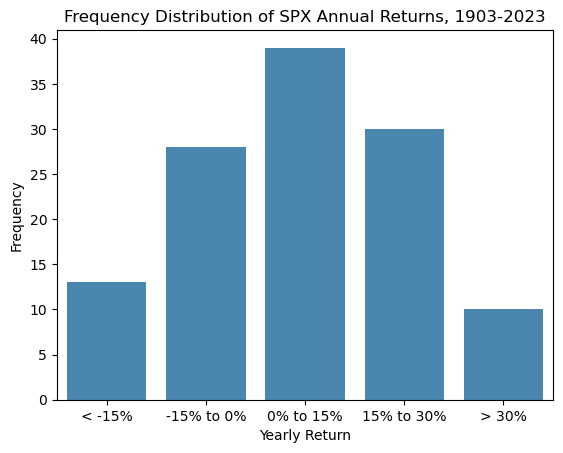

In [82]:
# Create yearly returns of S&P 500 plot
sns.countplot(x='ReturnRange', data=sp500, color='#3a89bf')

# Set axis labels and titles
plt.xlabel('Yearly Return')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of SPX Annual Returns, ' + start_date.strftime('%Y') + '-' + end_date.strftime('%Y'))

NameError: name 'start_date' is not defined

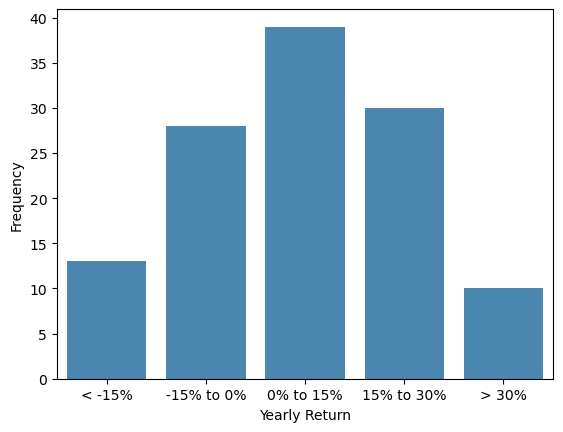

In [85]:
plotmachine.spx_returns(sp500, 'ReturnRange')